<a href="https://colab.research.google.com/github/felker/mpcs51087-MNIST/blob/main/mpcs51087_2024_p3m2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPCS 51087 Winter 2024

Project 3 milestone 2

https://amitness.com/2020/06/google-colaboratory-tips/



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn
import torch.nn.functional as F


import numpy
import math
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm


In [2]:
!pip install torchinfo

In [4]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  # get index of currently selected device
  print(torch.cuda.current_device())
  # get number of GPUs available
  print(torch.cuda.device_count())
  # get the name of the device
  print(torch.cuda.get_device_name(0))


False


In [5]:
!pip install wandb
import wandb
wandb.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
from torchinfo import summary

In [7]:
trainval_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 108468375.11it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9152678.04it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32428780.28it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3350427.15it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [10]:
# compare with CIFAR10
# see https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/01_conv_networks.ipynb

# test_data = torchvision.datasets.CIFAR10(
#     root="/lus/eagle/projects/datasets/CIFAR-10/",
#     train=False,
#     download=True,
#     transform=torchvision.transforms.ToTensor()
# )
# test_dataloader = torch.utils.data.DataLoader(test_data,
#     batch_size=128,
#     pin_memory=True,
#     shuffle=False,
#     num_workers=2)

# batch, (X, Y) = next(enumerate(test_dataloader))
# print(Y)  # tensor([3]) if bs=1


# dev = torch.device(
#     "cuda") if torch.cuda.is_available() else torch.device("cpu")


# def preprocess(x, y):
#     # CIFAR-10 is *color* images so 3 layers!
#     print(type(y)) # <class 'torch.Tensor'>
#     return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


# class WrappedDataLoader:
#     def __init__(self, dl, func):
#         self.dl = dl
#         self.func = func

#     def __len__(self):
#         return len(self.dl)

#     def __iter__(self):
#         for b in self.dl:
#             yield (self.func(*b))

# test_dataloader = WrappedDataLoader(test_dataloader, preprocess)
# batch, (X, Y) = next(enumerate(test_dataloader))
# print(Y) # tensor([3], device='cuda:0')

In [11]:
# 50K / 10K split
training_data, validation_data = torch.utils.data.random_split(trainval_data, [5.0/6.0, 1/6.0], generator=torch.Generator().manual_seed(55))

# no shuffling:
# training_data = torch.utils.data.Subset(trainval_data, range(50000))
# validation_data = torch.utils.data.Subset(trainval_data, range(50000, len(trainval_data)))

In [12]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 50000  examples, validation:  10000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


In [13]:
# confirm that the pixels are normalized from [0,255] original storage to [0,1.0] by simple /255 division
print(training_data[0][0].max())
print(training_data[0][0].min())

tensor(1.)
tensor(0.)


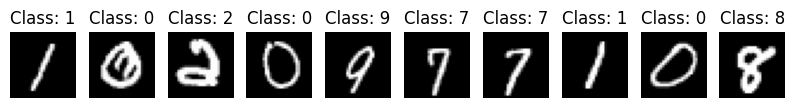

In [14]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [15]:
batch_size = 2048
test_batch_size = 1024

In [16]:
# The dataloader makes our dataset iterable
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                                   pin_memory=True, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                                   pin_memory=True, shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size,
                                                   pin_memory=True, shuffle=False, num_workers=2)

In [17]:
# batch, (X, Y) = next(enumerate(test_dataloader))
# print(X.view(-1, 28, 28))
# print(type(X.view(-1, 28, 28)))
# print(type(Y))
# print(Y)

In [18]:
# GPU
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # print(x)
    # print(type(x))
    # print(x.shape)
    # print(x.view(-1,28,28))
    # print(type(y))
    # print(y)
    return x.view(-1, 28, 28).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)
test_dataloader = WrappedDataLoader(test_dataloader, preprocess)

#print(next(enumerate(test_dataloader)))

In [19]:
print(dev)

cpu


# Fully connected network


In [20]:
class FullyConnectedClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        # MPCS 51087, Winter 2024. Milestone 2 spec
        self.layer_1 = nn.Linear(28*28, 800)
        self.activation_fn = nn.ReLU()
        self.layer_2 = nn.Linear(800, 10)

        # Default weight init, but set biases to zeros
        nn.init.kaiming_normal_(self.layer_1.weight, a=math.sqrt(5), mode='fan_in', nonlinearity='leaky_relu')
        nn.init.zeros_(self.layer_1.bias)
        nn.init.kaiming_normal_(self.layer_2.weight, a=math.sqrt(5), mode='fan_in', nonlinearity='leaky_relu')
        nn.init.zeros_(self.layer_2.bias)


    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)
        x = self.activation_fn(x)
        x = self.layer_2(x)

        return x

`nn.CrossEntropyLoss` expects integer labels. What it does internally is that it doesn't end up one-hot encoding the class label at all, but uses the label to index into the output probability vector to calculate the loss should you decide to use this class as the final label. This small but important detail makes computing the loss easier and is the equivalent operation to performing one-hot encoding, measuring the output loss per output neuron as every value in the output layer would be zero with the exception of the neuron indexed at the target class. Therefore, there's no need to one-hot encode your data if you have the labels already provided.



In [21]:
fnn_model = FullyConnectedClassifier()

# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# 'mean' is default reduction.
# Note that this case is equivalent to applying LogSoftmax on an input, followed by NLLLoss.
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(fnn_model.parameters(), lr=1.0)

## Switch model and dataloaders: GPU or CPU

In [22]:
# GPU
# print(fnn_model.cuda())
if torch.cuda.is_available():
  fnn_model.cuda()

# CPU
print(fnn_model)



FullyConnectedClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=800, bias=True)
  (activation_fn): ReLU()
  (layer_2): Linear(in_features=800, out_features=10, bias=True)
)


In [23]:
print(summary(fnn_model, input_size=(batch_size, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
FullyConnectedClassifier                 [2048, 10]                --
├─Flatten: 1-1                           [2048, 784]               --
├─Linear: 1-2                            [2048, 800]               628,000
├─ReLU: 1-3                              [2048, 800]               --
├─Linear: 1-4                            [2048, 10]                8,010
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
Total mult-adds (G): 1.30
Input size (MB): 6.42
Forward/backward pass size (MB): 13.27
Params size (MB): 2.54
Estimated Total Size (MB): 22.24


In [24]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, epoch_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        epoch_bar.update()

In [25]:
def evaluate(dataloader, model, loss_fn, eval_bar, batch_size):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            eval_bar.update()

    loss /= num_batches
    correct /= (num_batches*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [ ]:
%%time

epochs = 10
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, fnn_model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch
    # acc, loss = evaluate(train_dataloader, fnn_model, loss_fn)
    # print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the training loss and accuracy once per epoch
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Evaluate (train) Epoch {j}") as eval_bar_train_set:
        acc, loss = evaluate(train_dataloader, fnn_model, loss_fn, eval_bar_train_set, batch_size=batch_size)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    if len(val_dataloader) != 0:
        with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Evaluate (val) Epoch {j}") as eval_bar_val_set:
            acc_val, loss_val = evaluate(val_dataloader, fnn_model, loss_fn, eval_bar_val_set, batch_size=batch_size)
            print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluate (train) Epoch 0:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0: training loss: 0.542, accuracy: 80.934


Evaluate (val) Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0: validation loss: 0.548, accuracy: 80.449


Train Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluate (train) Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1: training loss: 0.316, accuracy: 88.521


Evaluate (val) Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: validation loss: 0.311, accuracy: 88.262


Train Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluate (train) Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2: training loss: 0.255, accuracy: 90.277


Evaluate (val) Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: validation loss: 0.251, accuracy: 90.068


Train Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluate (train) Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3: training loss: 0.234, accuracy: 90.982


Evaluate (val) Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: validation loss: 0.229, accuracy: 90.791


Train Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluate (train) Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4: training loss: 0.196, accuracy: 92.135


Evaluate (val) Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.196, accuracy: 91.846


Train Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluate (train) Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5: training loss: 0.179, accuracy: 92.613


Evaluate (val) Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.182, accuracy: 92.148


Train Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluate (train) Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([2048, 28, 28])


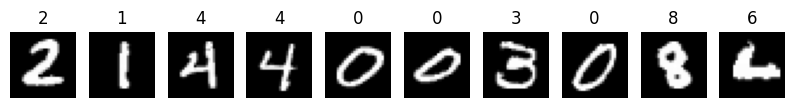

In [23]:
# Visualize how the model is doing on the first 10 training examples from next batch
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
fnn_model.eval()
batch = next(iter(train_dataloader))
print(batch[0].shape)
predictions = fnn_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,:,:].cpu(), cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Inference on test dataset




In [24]:
# acc_test, loss_test = evaluate(test_dataloader, fnn_model, loss_fn)
# print("Test loss: %.4f, Test accuracy: %.2f%%" % (loss_test, acc_test))

with tqdm(total=len(test_dataloader), position=0, leave=True, desc=f"Test set") as eval_bar_test_set:
    acc, loss = evaluate(test_dataloader, fnn_model, loss_fn, eval_bar_test_set, batch_size=test_batch_size)
    print(f"Test loss: {loss:.3f}, accuracy: {acc:.3f}")

Test set:   0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.133, accuracy: 93.848


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [25]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,:,:].cpu(), cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the validation data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


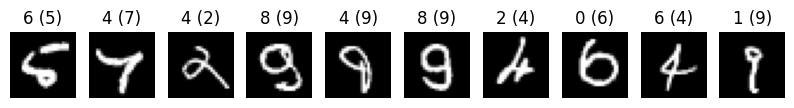

In [26]:
show_failures(fnn_model, test_dataloader)